In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_09c import *

# Image transformation with PIL

In [3]:
idx=4

In [4]:
make_rgb._order=0 # set to high order

In [5]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [6]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [7]:
il = get_il(tfms)

In [8]:
il[idx]

tensor([[[0.3098, 0.3294, 0.3765,  ..., 0.3176, 0.2471, 0.2314],
         [0.3216, 0.3255, 0.3569,  ..., 0.4471, 0.3137, 0.2627],
         [0.3255, 0.3176, 0.3569,  ..., 0.4667, 0.4118, 0.3255],
         ...,
         [0.3255, 0.3137, 0.3176,  ..., 0.6353, 0.8471, 0.8627],
         [0.3255, 0.3216, 0.3098,  ..., 0.7059, 0.8824, 0.9216],
         [0.3255, 0.3098, 0.2824,  ..., 0.7255, 0.8196, 0.7961]],

        [[0.2706, 0.2863, 0.3529,  ..., 0.4039, 0.3373, 0.3333],
         [0.2745, 0.2824, 0.3333,  ..., 0.5569, 0.4078, 0.3451],
         [0.2824, 0.2784, 0.3176,  ..., 0.6510, 0.5451, 0.4039],
         ...,
         [0.2745, 0.2706, 0.2745,  ..., 0.6706, 0.8667, 0.8471],
         [0.2706, 0.2706, 0.2667,  ..., 0.7451, 0.9020, 0.9098],
         [0.2824, 0.2667, 0.2471,  ..., 0.7647, 0.8471, 0.7843]],

        [[0.3176, 0.3294, 0.3922,  ..., 0.3725, 0.3176, 0.3255],
         [0.3255, 0.3294, 0.3804,  ..., 0.5020, 0.3608, 0.3373],
         [0.3294, 0.3176, 0.3647,  ..., 0.6196, 0.4824, 0.

In [9]:
il.items[idx]

PosixPath('/home/quantran/.fastai/data/imagenette/train/n03000684/n03000684_8890.JPEG')

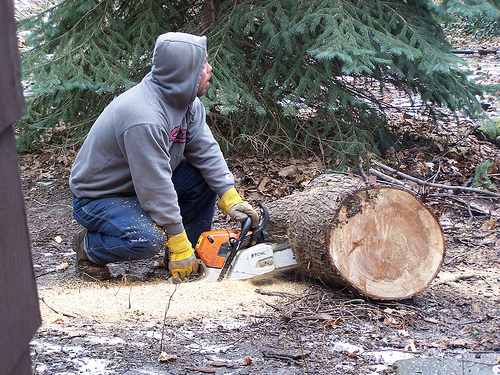

In [10]:
img = PIL.Image.open(il.items[idx])
img

In [11]:
img.size, type(img)

((500, 375), PIL.JpegImagePlugin.JpegImageFile)

In [12]:
img.getpixel((1,1))

(81, 70, 87)

In [13]:
import numpy as np

In [14]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[idx]))

2.62 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## PIL Resize with different resampling method

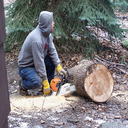

In [15]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

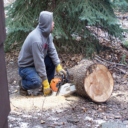

In [16]:
img.resize((128,128), resample=PIL.Image.BILINEAR)
# image is actually blurrer than the ANTIALIAS one

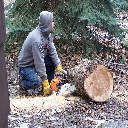

In [17]:
img.resize((128,128), resample=PIL.Image.NEAREST)
# distortion, but amplify small details

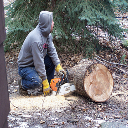

In [18]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)
# 2 resamplings (bit better)

## Flip using PIL

In [19]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [20]:
import random

def pil_random_flip(x):
    # to be put in tfms
    # flip vertically 50% of the time
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [21]:
# get a ready-to-send-to-GPU batch (bs=8) of imgs
il1 = get_il(tfms)
il1.items = [il1.items[idx]]*64
dl = DataLoader(il1, 8)
x = next(iter(dl))

In [22]:
x.shape,x.dtype

(torch.Size([8, 3, 128, 128]), torch.float32)

In [23]:
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

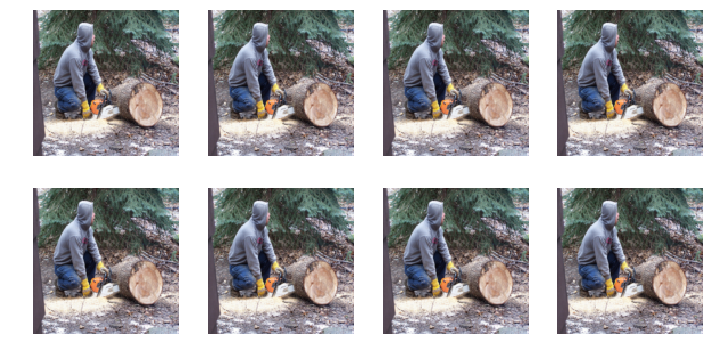

In [24]:
show_batch(x)

In [25]:
il1.tfms.append(pil_random_flip)

Reference on tfms and how it is used on image

```python
    def _get(self, i): 
        # use self.get(i) from children class of ItemList to get the item (see ImageList)
        # then apply tfms functions on it (with order)
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)
```

In [26]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,
 <function __main__.pil_random_flip(x)>]

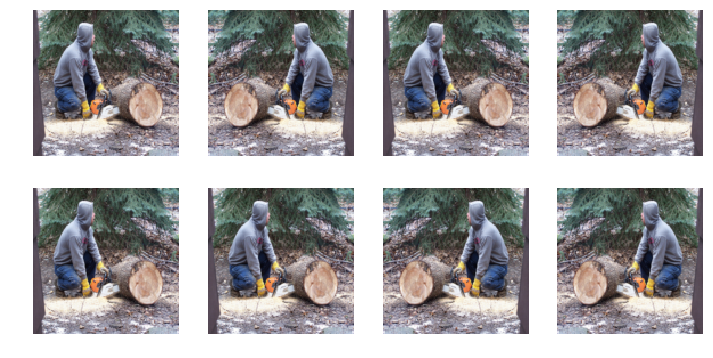

In [27]:
x = next(iter(dl))  # _getitem_ got called
show_batch(x)

#### Note: flip tfms should be done to the image while it is still a byte (uint8) stored in PIL img object. Doing flip tfms on tensor is slower!

In [28]:
make_rgb._order,ResizeFixed(128)._order,to_byte_tensor._order,to_float_tensor._order

(0, 10, 20, 30)

# PIL Transform class

In [29]:
class PilTransform(Transform): _order=11 # right after Resized (when it's still a PIL obj) and before Tensor conversion

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x


In [30]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

In [31]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,

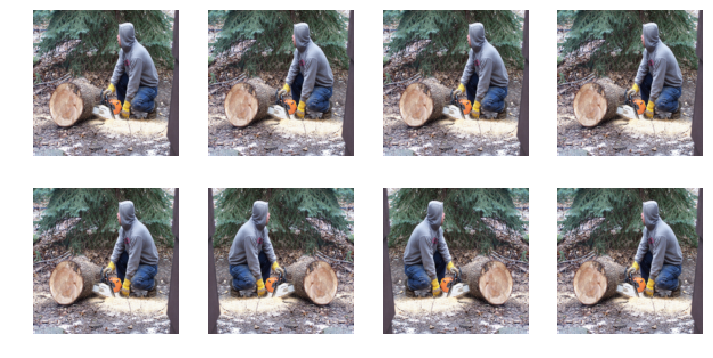

In [32]:
x = next(iter(dl))
show_batch(x)

## Dihedral group of PIL transform: horizontal + vertical flip and 4 90 degrees rotation

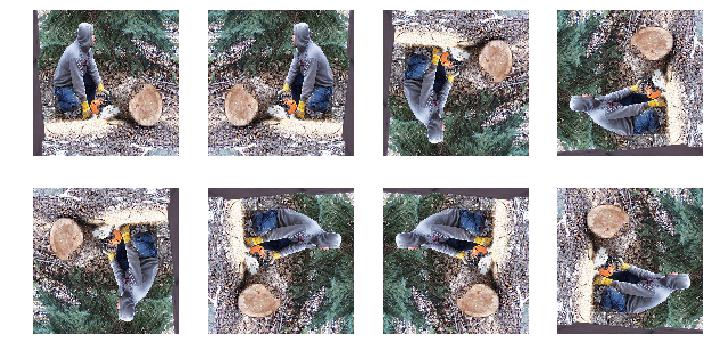

In [33]:
img = PIL.Image.open(il.items[idx])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img) # img.transpose(0) is already one transform, so doing nothing requires a separate case, then we have 7 different transformations.
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [34]:
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [35]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

In [36]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,

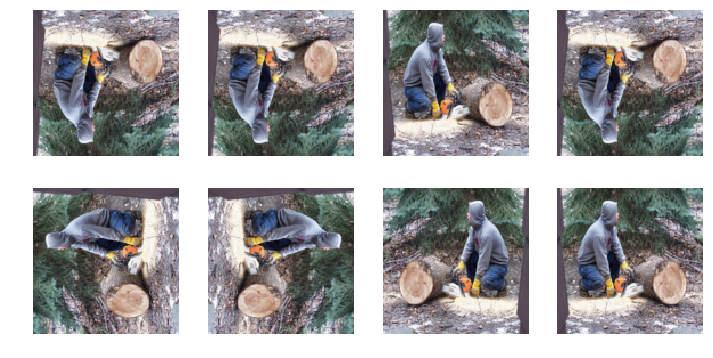

In [37]:
show_batch(next(iter(dl)))

## Random cropping

In [38]:
img = PIL.Image.open(il.items[idx])
img.size

(500, 375)

Note: we don't resize and crop, that does not make sense. We will crop first, then resize

#### NOte: if we decide to do transformation on byte (uint8), be extra careful when doing  'destructive' transformation (resize, crop, wasp ...). 

You don't want to do it in differente separate steps since they will round up each time -> you just add up the error.

-> Try to do them in 1 go (1 function if possible)

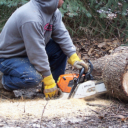

In [39]:
# provide top left + bottom right coords
img.crop((80,80,340,340)).resize((128,128), resample=PIL.Image.BILINEAR)

In [40]:
cnr2 = (80,80,340,340)
resample = PIL.Image.BILINEAR

In [41]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

107 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


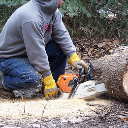

In [42]:
# we can do the crop and resize in the same call to transform, which will give a better result.
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [43]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

422 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a little bit slower but still fast enough for our purpose, so we will use this

In [44]:
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h] # square img with size min(w,h)

In [45]:
process_sz((128,128)),process_sz(128)

((128, 128), (128, 128))

# General Crop class

In [46]:
class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size

        # combine resize and crop into one call. self.get_corners will be overwritten
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h) # placeholder?

# Validation set crop class (Center Crop)

In [47]:


# This is only for validation set as we don't do data aug on the validation set (ignore TTA for now)
# We only do a light tfm where we zoon a bit to the center
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR): # zoom a bit to the center
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale] # calculate new crop size (does not have to be square)
    
    def get_corners(self, w, h, wc, hc): # calculate 2 corners (topleft bottomright) given crop size and center-crop requirement
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [48]:
# retire ResizeFixed
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

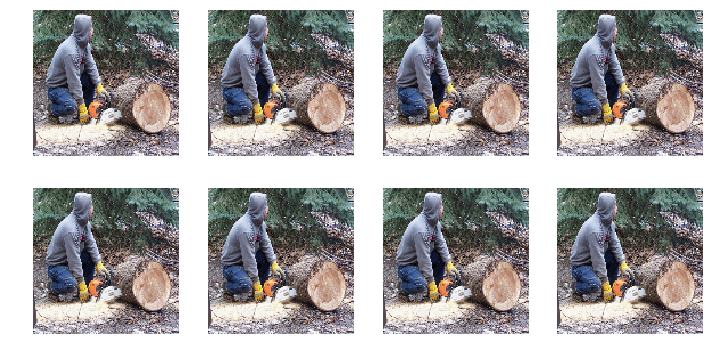

In [49]:
show_batch(next(iter(dl)))

# Train set crop class (Random resize crop)

#### Usual transformation for Imagenet 

consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost.

In [50]:
# TODO: study later?
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

In [51]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

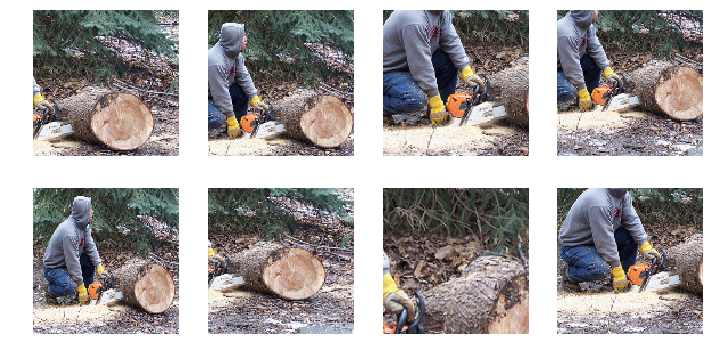

In [52]:
show_batch(next(iter(dl)))

Note that due to the [3/4 4/3] ratio crop, the obj in img may be squished or zoomed a bit. Jeremy argues that **this can contradict the domain knowledge, as the transformed img might not be reasonable within a certain knowledge anymore**

Also note at least half of these transformed image will be noisy, but deep model can result in good score -> it's okay to have noisy labels, as long as it's not too biased

## Perspective warping (alternative to Random Resize Crop)


To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance, if we have an image with corners in:

(60,60,60,280,280,280,280,60)

(top/left, bottom/left, bottom/right, top/right) then a warped version is:

(90,60,30,280,310,280,250,60)

We need to solve this [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). The equation solver is called torch.solve in PyTorch.

In [53]:
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])



In [54]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

In [55]:
c = find_coeffs(src, targ)
c

[tensor(1.2500),
 tensor(-0.5692),
 tensor(90.),
 tensor(0.),
 tensor(0.7812),
 tensor(60.),
 tensor(0.),
 tensor(-0.0033)]

In [56]:
img.size

(500, 375)

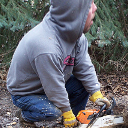

In [57]:
# warping and resize
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample) #??

In [58]:
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

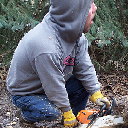

In [59]:
warp(img,(128,128),src, PIL.Image.NEAREST)

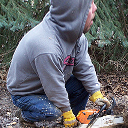

In [60]:
warp(img,(128,128),src, PIL.Image.BICUBIC)

In [61]:
def uniform(a,b): return a + (b-a) * random.random() # 1 from uniform dist b/t a and b

In [62]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
#         up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
#         left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])


        # limit the magnitude to avoid black padding appears when target points are outside of image
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [63]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 200, magnitude=0.3), to_byte_tensor, to_float_tensor]

In [64]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>]

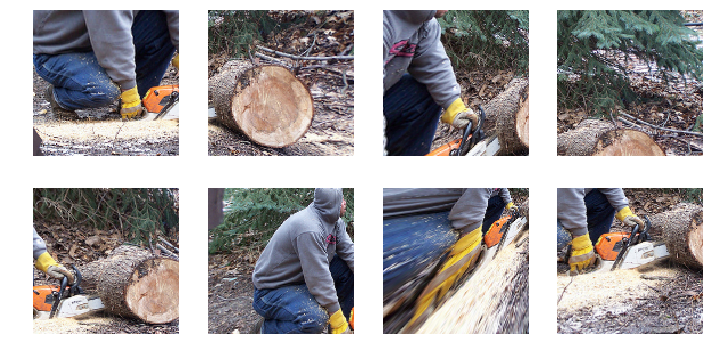

In [65]:
x = next(iter(dl))
show_batch(x)

# Slow byte -> float conversion fix

In [66]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f1bf93dd320>),
 (11, <__main__.PilRandomDihedral at 0x7f1bf8487940>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

There is no fine reason why we need an intermediate step (convert to byte tensor) in order to get float tensor ready for GPU

Previously
```python
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)

def to_float_tensor(item): return item.float().div_(255.)
```

In [67]:
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [68]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

1.46 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
%timeit -n 10 np_to_float(img)

820 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Augmentation on GPU


Where all our transformations should happen **AFTER** a batch. This transformation will be known as **batch data augmentation** and we will do them **whole batch at a time (batch-wise) via Pytorch operations**

You can **write your own augmentation for your domain's data types**, and have them run on the GPU

## 1. Generate grid map

Grid map size (bs,h,w,2) for a COORDINATE grid (h,w) (before tfms and a grid (h,w) after tfms) for all items in the batch. h and w does not have to be the same size as the img size in the batch

Use pytorch functions: ```F.affine_grid``` / ```F.grid_sample```

In [70]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [71]:
dl = DataLoader(il1, 64)

In [72]:
x = next(iter(dl))

In [73]:
x.size() # already transformed batch

torch.Size([64, 3, 128, 128])

In [74]:
from torch import FloatTensor

def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    
    # tensor size w of equally value between -1 and 1 (coordinate values)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1]) 
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    
    # tensor size h of equally value between -1 and 1
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1]) 
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

In [75]:
grid = affine_grid_cpu(x.size())
grid.shape

torch.Size([64, 128, 128, 2])

In [76]:
grid[0,...,0] # [-1 -> 1]

tensor([[-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
        [-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
        [-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
        ...,
        [-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
        [-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
        [-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000]])

In [77]:
grid[0,...,1]
# -1
# ↓
# 1

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9843, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
        [-0.9685, -0.9685, -0.9685,  ..., -0.9685, -0.9685, -0.9685],
        ...,
        [ 0.9685,  0.9685,  0.9685,  ...,  0.9685,  0.9685,  0.9685],
        [ 0.9843,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])

In [78]:
%timeit -n 10 grid = affine_grid_cpu(x.size()) # slow on cpu

3.15 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
# create grid  that dispatches on CPU and uses PYtorch's on GPU
# note that we can even resize the grid using 'size' params
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    
    #for CPU
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    # for GPU
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [80]:
grid = affine_grid(x,128)
grid.shape

torch.Size([64, 128, 128, 2])

## 2. Affine multiplication

apply the affine transforms (which is a matrix multiplication) and the coord transforms to that grid map

In [81]:
from torch import stack,zeros_like,ones_like

### Rotation

In 2D an affine transformation has the form y = A@x + b where A is a 2x2 matrix and b a vector with 2 coordinates. It's usually represented by the 3x3 matrix

In [83]:
def rotation_matrix(thetas):
    # create ratation matrix to be multiplied to original matrix
    # params: thetas are list of angles for rotation
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [84]:
x.shape

torch.Size([64, 3, 128, 128])

In [85]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)
# thetas = torch.empty(x.size(0)).uniform_(-90,90)
thetas.shape

torch.Size([64])

In [86]:
thetas # 64 angle degrees between -30 and 30

tensor([-28.0047, -18.0174, -18.3871, -16.7216,  16.4602,   9.5154,  20.4306,
          0.9047, -28.4815, -22.9844,   7.6258, -12.2565, -21.0685, -26.8466,
        -22.7979, -24.2616,  25.4127,  17.7753, -23.9837,  -4.2382,   2.5741,
        -25.4287, -12.3003, -15.5500,  27.7371, -27.5107, -23.0907,  -9.7776,
        -20.9025,  13.5261, -23.2130,  -3.7373, -27.2378, -19.5614,   7.8581,
         -7.3582,  17.5453,  22.7810,  -3.9451,   9.0153, -12.2541, -21.2014,
         -5.7940, -10.2606, -22.6216,  -4.0509,  -1.9910,   0.2716,  24.7472,
         17.2195,  21.4610,  27.4188,  25.8091,  22.6994, -24.3644,  -7.4574,
         20.5866,  -3.6452,  -5.3416, -29.3118, -12.0414,   7.6354, -15.4894,
         22.3993])

In [87]:
m = rotation_matrix(thetas)
m.shape
# rotation matrix for 64 angles

torch.Size([64, 3, 3])

In [88]:
grid.shape,grid.view(64,-1,2).shape

(torch.Size([64, 128, 128, 2]), torch.Size([64, 16384, 2]))

In 2D an affine transformation has the form y = Ax + b where A is a 2x2 matrix and b a vector with 2 coordinates

In [89]:
a = m[:,:2,:2]
b = m[:, 2:,:2]
a.shape,b.shape

(torch.Size([64, 2, 2]), torch.Size([64, 1, 2]))

In [90]:
tfm_grid = (grid.view(64,-1,2) @ a + b).view(64, 128, 128, 2)
# rotated grid for 64 angles

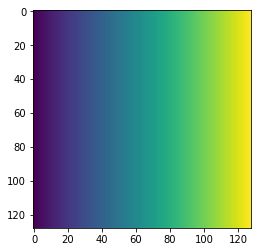

In [91]:
plt.imshow(grid[0,...,0] )

(<matplotlib.image.AxesImage at 0x7f1bf83bda20>, tensor(-0.4888))

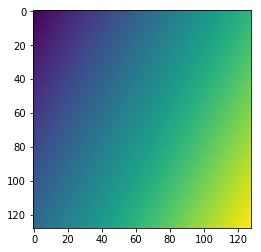

In [92]:
plt.imshow(tfm_grid[0,...,0] ), thetas[0]

(<matplotlib.image.AxesImage at 0x7f1bf86e00b8>, tensor(0.2873))

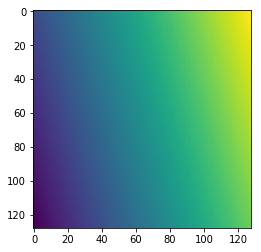

In [93]:
plt.imshow(tfm_grid[4,...,0] ), thetas[4]

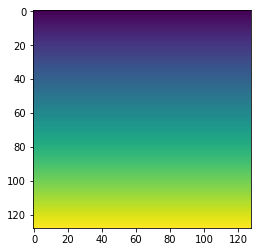

In [94]:
plt.imshow(grid[0,...,1] )

(<matplotlib.image.AxesImage at 0x7f1bf81c45f8>, tensor(-0.4888))

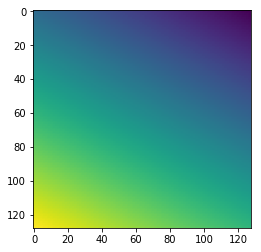

In [95]:
plt.imshow(tfm_grid[0,...,1] ), thetas[0]

(<matplotlib.image.AxesImage at 0x7f1bf0f2f898>, tensor(0.2873))

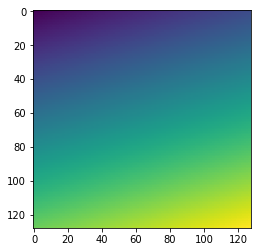

In [96]:
plt.imshow(tfm_grid[4,...,1] ), thetas[4]

### Benchmarking different other way to do A@x + b on CPU

In [155]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]


14.4 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]


7.82 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [157]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]


14.3 ms ± 78.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [158]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)


7.67 ms ± 61.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### And on GPU

In [159]:
grid = grid.cuda()
m = m.cuda()

In [160]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]


The slowest run took 302.40 times longer than the fastest. This could mean that an intermediate result is being cached.
3.23 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [161]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]


87.2 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [162]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]


79.7 µs ± 6.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [163]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)


58.2 µs ± 9.71 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3. Interpolate

interpolate the values of the final pixels we want from the initial images in the batch, according to the transformed grid map

In [98]:
# use bmm since it's the fastest
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

The interpolation to find our coordinates back is done by grid_sample.

In [99]:
tfm_grid.shape, x.shape

(torch.Size([64, 128, 128, 2]), torch.Size([64, 3, 128, 128]))

In [101]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

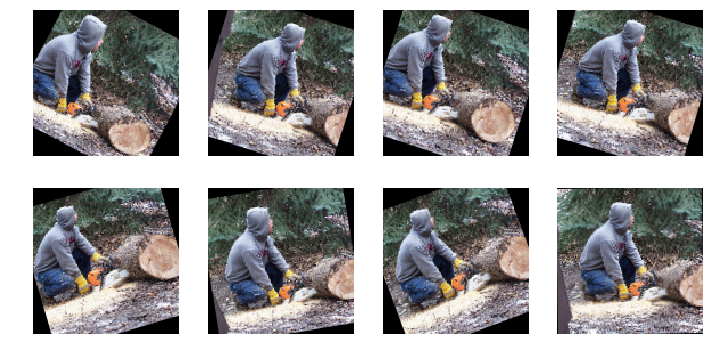

In [102]:
show_batch(tfm_x, r=2)

In [103]:
# padding mode to elimininate black padding
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

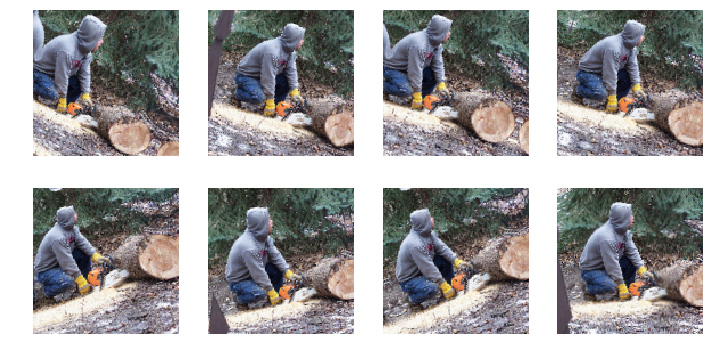

In [104]:
show_batch(tfm_x, r=2)

# Write the GPU rotate transformation function

In [105]:
def rotate_batch(x, size, degrees):
    # rotation transform with 64 angles in [-degrees,degrees] and crop to size 'size'
    # one angle for each image in a batch
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:,:2,:2].unsqueeze(1) + m[:,2,:2][:,None,None]
    return F.grid_sample(x, tfm_grid)

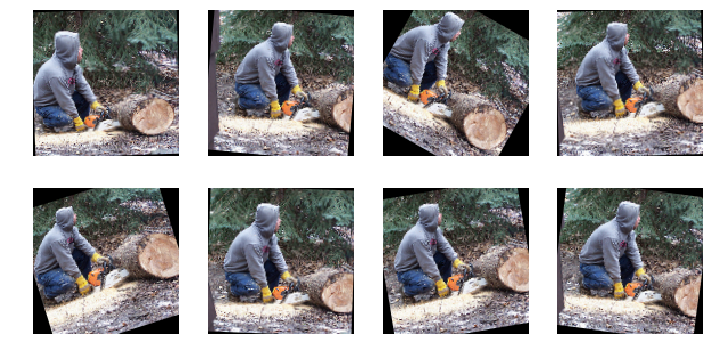

In [106]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [108]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

3.32 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## JIT (Just in time) version

In [109]:
from torch import Tensor

In [110]:
from torch.jit import script

@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

In [112]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

3.14 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Faster with F.affine_grid

```F.affine_grid``` can even combine grid generation and affine transformation (matrix multiplication) **if we just want to do an affine transformation.**

In [113]:
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x.cuda(), grid)

In [119]:
temp = rotate_batch(x.cuda(), 128, 30)

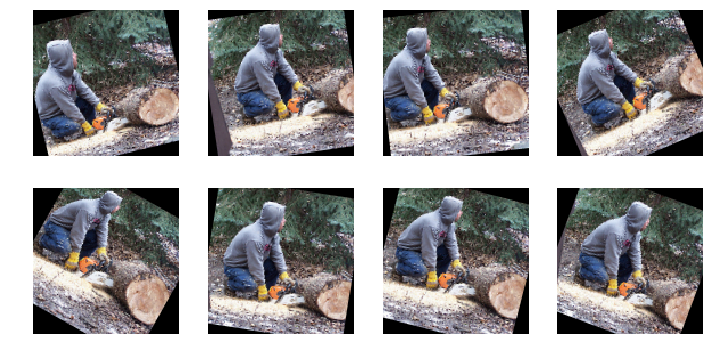

In [124]:
show_batch(temp.cpu(),r=2)

In [117]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

2 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
